In [7]:
# https://www.kaggle.com/datasets/shubhammehta21/movie-lens-small-latest-dataset

In [1]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
# ratings.csv (평가)
ratings_df=pd.read_csv('./ml-latest-small/ratings.csv')
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [3]:
# movies.csv (영화정보: 제목, 장르)
movies_df=pd.read_csv('./ml-latest-small/movies.csv')
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [4]:
#tags.csv : 태그
tags_df=pd.read_csv('./ml-latest-small/tags.csv')
tags_df

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


# [ Genres를 이용한 movie representation ]

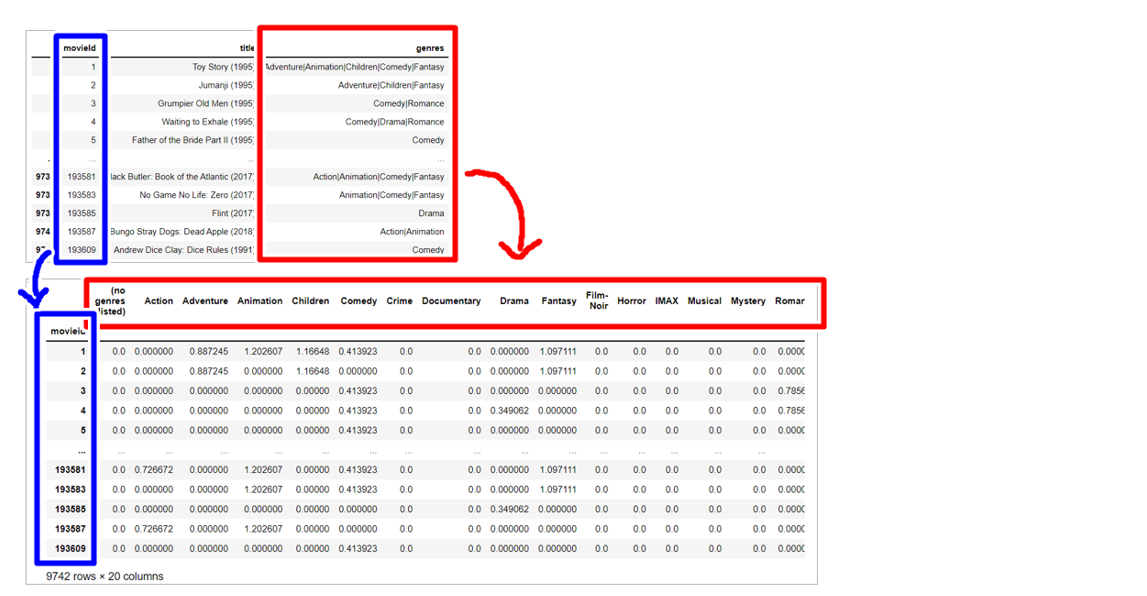

In [5]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


## 1. 총영화수 

** 문서수

In [6]:
total_count=len(movies_df) #총 영화수
total_count

9742

## 2. 특정 장르가 포함된 영화수

In [7]:
#장르별 갯수를 딕트로 변화 {장르:갯수}
genres_tmp=[genres for i in movies_df['genres'] for genres in i.split('|')]
total_genres =list(set(genres_tmp)) # 장르 종류

genre_count={i:genres_tmp.count(i) for i in total_genres} #TF
genre_count


{'Film-Noir': 87,
 'Sci-Fi': 980,
 'Animation': 611,
 'Crime': 1199,
 'Romance': 1596,
 'Mystery': 573,
 'Thriller': 1894,
 'Action': 1828,
 'IMAX': 158,
 'Adventure': 1263,
 'Fantasy': 779,
 'Drama': 4361,
 'Documentary': 440,
 'War': 382,
 'Children': 664,
 '(no genres listed)': 34,
 'Horror': 978,
 'Western': 167,
 'Musical': 334,
 'Comedy': 3756}

# 3. IDF
### IDF=np.log10(전체영화수/특정 장르가 포함된 영화수)

In [8]:
# 장르별 가중치(IDF) np.log10(전체영화수/특정 장르가 포함된 영화수)
genre_idf={i: np.log10(total_count/genre_count[i])for i in genre_count}
genre_idf

{'Film-Noir': 2.0491288726171324,
 'Sci-Fi': 0.9974220495432563,
 'Animation': 1.2026069149931968,
 'Crime': 0.9098289421369025,
 'Romance': 0.7856152382210405,
 'Mystery': 1.2304935032683613,
 'Thriller': 0.7112681505684965,
 'Action': 0.7266719338379385,
 'IMAX': 1.7899910382813284,
 'Adventure': 0.8872447746804204,
 'Fantasy': 1.0971106675631865,
 'Drama': 0.3490620385623247,
 'Documentary': 1.3451954487495636,
 'War': 1.4065847623240424,
 'Children': 1.1664800458677336,
 '(no genres listed)': 2.457169208193496,
 'Horror': 0.9983092704481497,
 'Western': 1.7659316540881678,
 'Musical': 1.4649016584241867,
 'Comedy': 0.4139225416416778}

# 4. create genre representations

In [9]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [10]:
# create genre representations
genre_representation=[]
for idx,genre in enumerate(movies_df['genres']):
    dict_tmp={i:genre_idf[i] for i in genre.split('|')}
    dict_tmp['movieid']=movies_df['movieId'][idx]
    genre_representation.append(dict_tmp)
genre_representation=pd.DataFrame(genre_representation).set_index('movieid') #movieid를 index(행이름)으로 설정
genre_representation=genre_representation.fillna(0) # NA -> 0으로 채움
genre_representation=genre_representation.sort_index(axis=1) # 열이름으로 오름 차순 정렬
genre_representation

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.887245,1.202607,1.16648,0.413923,0.0,0.0,0.000000,1.097111,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.887245,0.000000,1.16648,0.000000,0.0,0.0,0.000000,1.097111,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.000000,0.00000,0.413923,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.785615,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.000000,0.000000,0.00000,0.413923,0.0,0.0,0.349062,0.000000,0.0,0.0,0.0,0.0,0.0,0.785615,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.000000,0.000000,0.00000,0.413923,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.726672,0.000000,1.202607,0.00000,0.413923,0.0,0.0,0.000000,1.097111,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
193583,0.0,0.000000,0.000000,1.202607,0.00000,0.413923,0.0,0.0,0.000000,1.097111,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
193585,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.349062,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [11]:
genre_representation.loc[1]

(no genres listed)    0.000000
Action                0.000000
Adventure             0.887245
Animation             1.202607
Children              1.166480
Comedy                0.413923
Crime                 0.000000
Documentary           0.000000
Drama                 0.000000
Fantasy               1.097111
Film-Noir             0.000000
Horror                0.000000
IMAX                  0.000000
Musical               0.000000
Mystery               0.000000
Romance               0.000000
Sci-Fi                0.000000
Thriller              0.000000
War                   0.000000
Western               0.000000
Name: 1, dtype: float64

# [Tag를 이용한 Movie Representation] 

In [12]:
tags_df

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


# 1. 전체 영화수

In [13]:
total_movie_count=len(set(tags_df['movieId'])) #전체 영화수
total_movie_count

1572

# 2. tag TF 

In [14]:
# get unique tag
total_tags = [i.split(',') for i in tags_df['tag']] # tag가 (,)구분자로 여러개 있을 경우
total_tags=[j.strip() for i in total_tags for j in i] # tag 양쪽 공백 제거
unique_tags = list(set(total_tags))

print(unique_tags)

['Colin Farrell', 'bad jokes', 'homosexuality', 'Jaime Pressly', 'graphic design', 'Native Americans', 'Great movie', 'saints', 'Andrew Lloyd Weber', 'Documentary', 'Tolstoy', 'slow paced', 'espionage', 'original', 'lion', 'Olympics', 'Keanu Reeves', 'infertility', 'stop using useless characters for filler', 'Turkey', 'bluegrass', 'Julianne Moore', 'surfing', 'brutality', 'Paul Rudd', 'diner', 'Coen Brothers', 'Prince', 'rug', '06 Oscar Nominated Best Movie - Animation', 'double life', 'Mystery', 'Soundtrack', 'notable soundtrack', 'innovative', 'World War II', 'acting', 'intelligent sci-fi', 'Nazis', 'gangsters', 'missionary', 'adoption', 'oldie but goodie', 'dark comedy', 'serial killer', 'Oscar Wilde', 'biblical references', 'anthology', 'heartwarming', 'mel gibson', 'I see dead people', 'great acting', 'assassin-in-training (scene)', 'mockumentary', 'Police', 'deafness', 'Magic', 'gruesome', 'sentimental', 'journalism', 'a dingo ate my baby', 'economics', 'Big Brothers', 'Nun', 'ch

In [15]:
print(total_tags)

['funny', 'Highly quotable', 'will ferrell', 'Boxing story', 'MMA', 'Tom Hardy', 'drugs', 'Leonardo DiCaprio', 'Martin Scorsese', 'way too long', 'Al Pacino', 'gangster', 'mafia', 'Al Pacino', 'Mafia', 'holocaust', 'true story', 'twist ending', 'Anthony Hopkins', 'courtroom drama', 'twist ending', 'britpop', 'indie record label', 'music', 'dumpster diving', 'Sustainability', 'romantic comedy', 'wedding', 'painter', 'bloody', 'black hole', 'sci-fi', 'time-travel', 'fantasy', 'magic board game', 'Robin Williams', 'beautiful scenery', 'epic', 'historical', 'inspirational', 'Medieval', 'mel gibson', 'Oscar (Best Cinematography)', 'revenge', 'sword fight', 'black comedy', 'Christina Ricci', 'Christopher Lloyd', 'dark comedy', 'family', 'gothic', 'Al Pacino', 'Andy Garcia', 'Classic', 'Francis Ford Coppola', 'mafia', 'black comedy', 'Christina Ricci', 'Christopher Lloyd', 'Family', 'gothic', 'quirky', 'family', 'funny', 'Macaulay Culkin', 'sequel', 'animation', 'Disney', 'funny', 'original',

In [16]:
print(len(total_tags))
print(len(unique_tags))

3683
1589


In [17]:
# tag TF
tag_tf={i:total_tags.count(i) for i in unique_tags}

tag_tf

{'Colin Farrell': 1,
 'bad jokes': 1,
 'homosexuality': 1,
 'Jaime Pressly': 1,
 'graphic design': 2,
 'Native Americans': 1,
 'Great movie': 1,
 'saints': 1,
 'Andrew Lloyd Weber': 1,
 'Documentary': 1,
 'Tolstoy': 1,
 'slow paced': 1,
 'espionage': 2,
 'original': 2,
 'lion': 1,
 'Olympics': 2,
 'Keanu Reeves': 2,
 'infertility': 1,
 'stop using useless characters for filler': 1,
 'Turkey': 1,
 'bluegrass': 1,
 'Julianne Moore': 1,
 'surfing': 2,
 'brutality': 3,
 'Paul Rudd': 2,
 'diner': 1,
 'Coen Brothers': 7,
 'Prince': 1,
 'rug': 1,
 '06 Oscar Nominated Best Movie - Animation': 3,
 'double life': 1,
 'Mystery': 3,
 'Soundtrack': 2,
 'notable soundtrack': 2,
 'innovative': 1,
 'World War II': 9,
 'acting': 1,
 'intelligent sci-fi': 1,
 'Nazis': 2,
 'gangsters': 3,
 'missionary': 1,
 'adoption': 2,
 'oldie but goodie': 1,
 'dark comedy': 21,
 'serial killer': 8,
 'Oscar Wilde': 1,
 'biblical references': 1,
 'anthology': 1,
 'heartwarming': 8,
 'mel gibson': 1,
 'I see dead people

# 3. tag IDF

### IDF=np.log10(전체영화수/특정 tag가 포함된 영화수)

In [18]:
tag_idf={i: np.log10(total_movie_count/tag_tf[i]) for i in unique_tags}
tag_idf

{'Colin Farrell': 3.196452541703389,
 'bad jokes': 3.196452541703389,
 'homosexuality': 3.196452541703389,
 'Jaime Pressly': 3.196452541703389,
 'graphic design': 2.895422546039408,
 'Native Americans': 3.196452541703389,
 'Great movie': 3.196452541703389,
 'saints': 3.196452541703389,
 'Andrew Lloyd Weber': 3.196452541703389,
 'Documentary': 3.196452541703389,
 'Tolstoy': 3.196452541703389,
 'slow paced': 3.196452541703389,
 'espionage': 2.895422546039408,
 'original': 2.895422546039408,
 'lion': 3.196452541703389,
 'Olympics': 2.895422546039408,
 'Keanu Reeves': 2.895422546039408,
 'infertility': 3.196452541703389,
 'stop using useless characters for filler': 3.196452541703389,
 'Turkey': 3.196452541703389,
 'bluegrass': 3.196452541703389,
 'Julianne Moore': 3.196452541703389,
 'surfing': 2.895422546039408,
 'brutality': 2.7193312869837265,
 'Paul Rudd': 2.895422546039408,
 'diner': 3.196452541703389,
 'Coen Brothers': 2.351354501689132,
 'Prince': 3.196452541703389,
 'rug': 3.196452

# 4. create tag representations

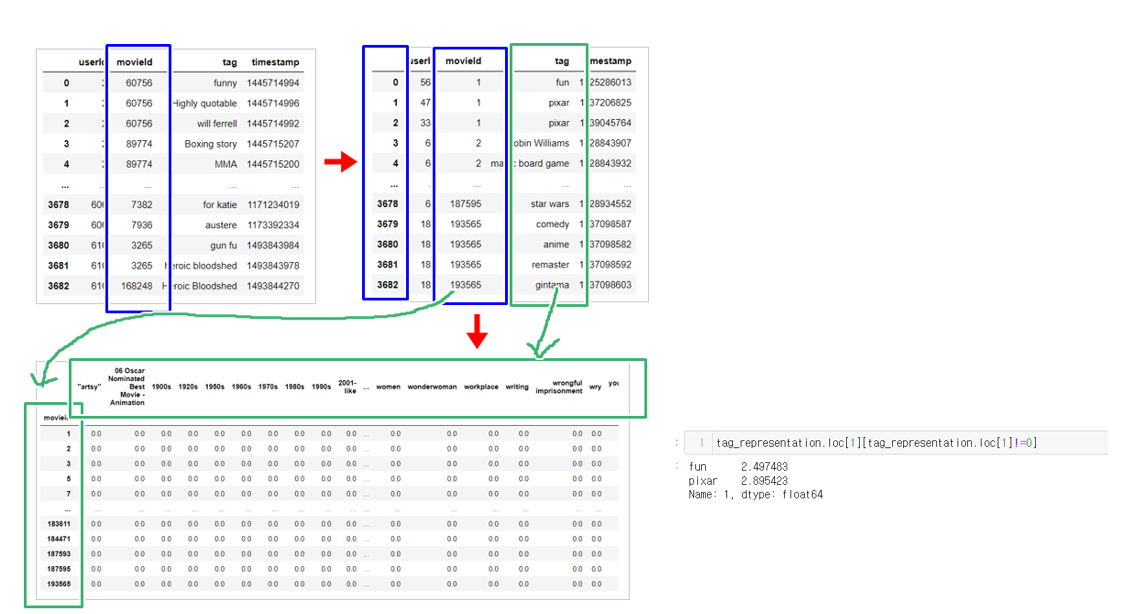

In [19]:
tags_df

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


In [34]:
tag_tmp=tags_df.sort_values('movieId').reset_index(drop=True)
tag_tmp

,userId,movieId,tag,timestamp
0,567,1,fun,1525286013
1,474,1,pixar,1137206825
2,336,1,pixar,1139045764
3,62,2,Robin Williams,1528843907
4,62,2,magic board game,1528843932
...,...,...,...,...
3678,62,187595,star wars,1528934552
3679,184,193565,comedy,1537098587
3680,184,193565,anime,1537098582
3681,184,193565,remaster,1537098592


In [36]:
#movie ID별 tag 정리
tag_dict={}
tmp=0
for idx,i in enumerate(tag_tmp['movieId']):
    if tmp!=i:
        tmp=i
        tag_dict[i]=[]
    tag_dict[i].append(tag_tmp['tag'][idx].strip())
tag_dict

{1: ['fun', 'pixar', 'pixar'],
 2: ['Robin Williams', 'magic board game', 'fantasy', 'game'],
 3: ['old', 'moldy'],
 5: ['remake', 'pregnancy'],
 7: ['remake'],
 11: ['president', 'politics'],
 14: ['politics', 'president'],
 16: ['Mafia'],
 17: ['Jane Austen'],
 21: ['Hollywood'],
 22: ['serial killer'],
 25: ['alcoholism'],
 26: ['Shakespeare'],
 28: ['Jane Austen', 'In Netflix queue'],
 29: ['kidnapping'],
 31: ['teacher', 'high school'],
 32: ['Brad Pitt',
  'Bruce Willis',
  'mindfuck',
  'twist ending',
  'time travel',
  'Post apocalyptic',
  'remake',
  'post-apocalyptic',
  'time travel',
  'time travel'],
 34: ['Animal movie',
  'pigs',
  'villain nonexistent or not needed for good story'],
 36: ['death penalty', 'Nun'],
 38: ['twins'],
 39: ['Emma',
  'Jane Austen',
  'seen more than once',
  'quotable',
  'Paul Rudd',
  'funny',
  'chick flick'],
 40: ['South Africa', 'In Netflix queue'],
 41: ['Shakespeare'],
 43: ['England'],
 45: ['Journalism'],
 46: ['wedding'],
 47: ['

In [85]:
# create tag representations
tag_representation=[]

for movie_id, tags in tag_dict.items():
    dict_tmp={tag:tag_idf[tag] for tag in set(tags)}
    dict_tmp['movieid']=movie_id
    tag_representation.append(dict_tmp)
    
tag_representation=pd.DataFrame(tag_representation)
tag_representation=tag_representation.set_index('movieid') #'movieid'로 인덱스 설정

tag_representation=tag_representation.sort_index(axis=1) #열방향 정렬
display(tag_representation)

,"""artsy""",06 Oscar Nominated Best Movie - Animation,1900s,1920s,1950s,1960s,1970s,1980s,1990s,2001-like,...,women,wonderwoman,workplace,writing,wrongful imprisonment,wry,younger men,zither,zoe kazan,zombies
movieid,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
184471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
tag_representation.loc[1].dropna()

fun      2.497483
pixar    2.895423
Name: 1, dtype: float64

In [88]:
tag_representation.loc[2].dropna()

Robin Williams      2.719331
fantasy             2.418301
game                3.196453
magic board game    3.196453
Name: 2, dtype: float64

# [Final Movie Represenation ]
- genre와 tag로 만들어진 representation을 합쳐서 각 movie의 vector로 만든다

In [89]:
tag_representation.shape

(1572, 1589)

In [90]:
genre_representation.shape

(9742, 20)

In [91]:
movie_representation = pd.concat([genre_representation, tag_representation], axis=1).fillna(0)
print(movie_representation.shape)
display(movie_representation.describe())

(9742, 1609)


,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,women,wonderwoman,workplace,writing,wrongful imprisonment,wry,younger men,zither,zoe kazan,zombies
count,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,...,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000
mean,0.008576,0.136354,0.115027,0.075425,0.079506,0.159587,0.111978,0.060756,0.156257,0.087728,...,0.000328,0.000328,0.000328,0.000837,0.000328,0.000328,0.000328,0.000328,0.000328,0.001241
std,0.144915,0.283726,0.298052,0.291593,0.293989,0.201476,0.298916,0.279366,0.173581,0.297591,...,0.032385,0.032385,0.032385,0.047715,0.032385,0.032385,0.032385,0.032385,0.032385,0.054775
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.413923,0.000000,0.000000,0.349062,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.457169,0.726672,0.887245,1.202607,1.166480,0.413923,0.909829,1.345195,0.349062,1.097111,...,3.196453,3.196453,3.196453,2.719331,3.196453,3.196453,3.196453,3.196453,3.196453,2.418301


# [ Contents 유사도 평가 ]
- Cosine similarity를 사용

https://wikidocs.net/24603
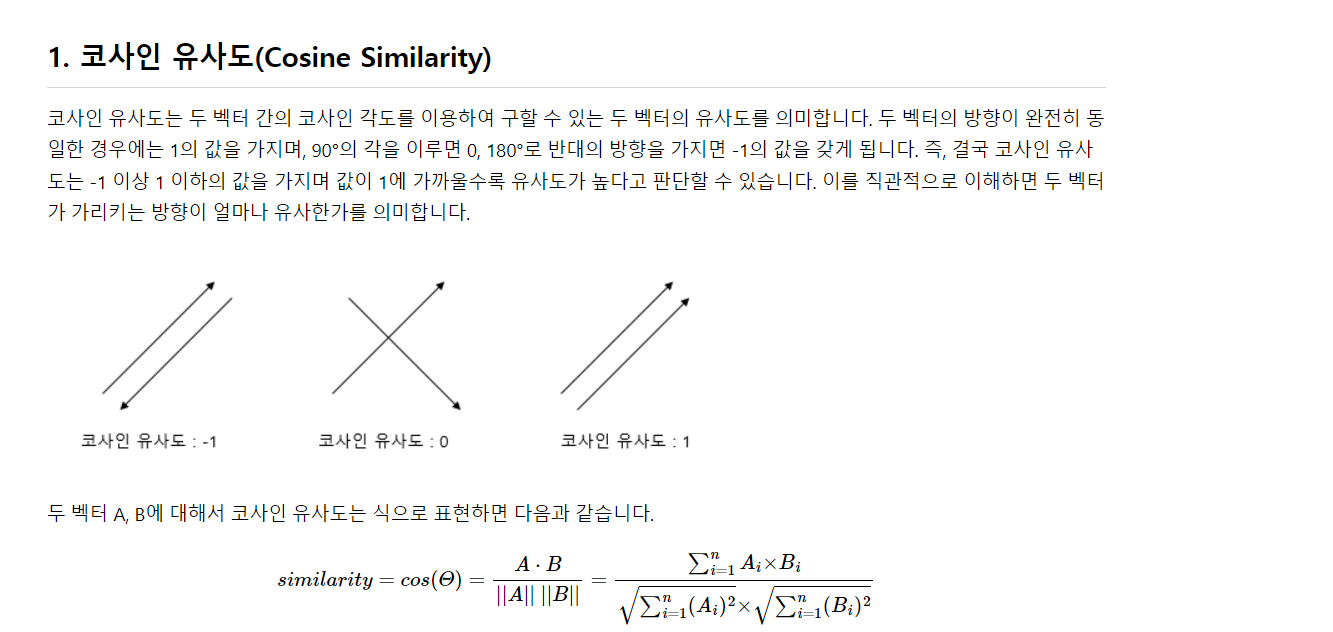

[참고] 유사도 측정 - 유클리디안 거리, 코사인 유사도
https://0equal2.tistory.com/141 

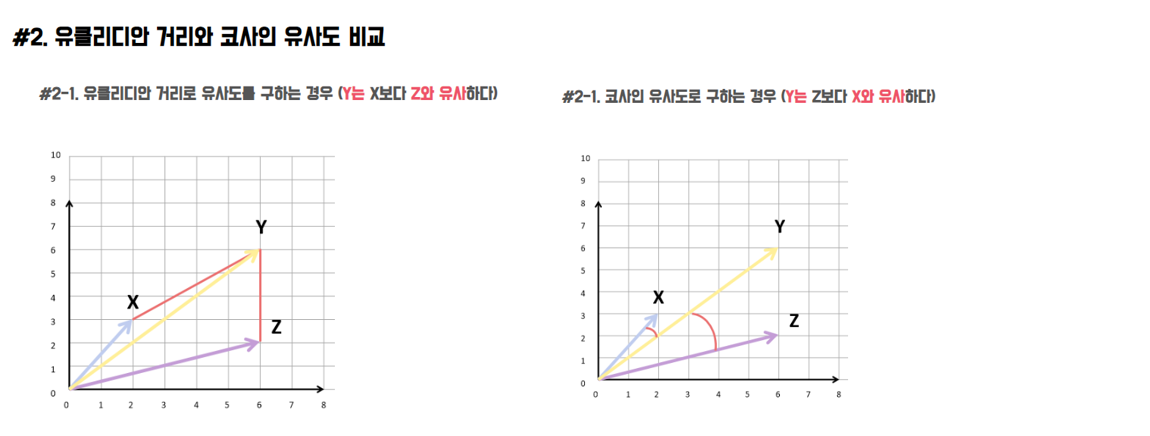

https://specialscene.tistory.com/48

In [92]:
print(movie_representation.head())

         (no genres listed)  Action  Adventure  Animation  Children    Comedy  \
movieid                                                                         
1                       0.0     0.0   0.887245   1.202607   1.16648  0.413923   
2                       0.0     0.0   0.887245   0.000000   1.16648  0.000000   
3                       0.0     0.0   0.000000   0.000000   0.00000  0.413923   
4                       0.0     0.0   0.000000   0.000000   0.00000  0.413923   
5                       0.0     0.0   0.000000   0.000000   0.00000  0.413923   

         Crime  Documentary     Drama   Fantasy  ...  women  wonderwoman  \
movieid                                          ...                       
1          0.0          0.0  0.000000  1.097111  ...    0.0          0.0   
2          0.0          0.0  0.000000  1.097111  ...    0.0          0.0   
3          0.0          0.0  0.000000  0.000000  ...    0.0          0.0   
4          0.0          0.0  0.349062  0.000000  ...

In [93]:
from sklearn.metrics.pairwise import cosine_similarity
cos_sim = cosine_similarity(movie_representation, movie_representation)
result_df = pd.DataFrame(data=cos_sim, index=movie_representation.index, columns=movie_representation.index)
result_df

movieid,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
movieid,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.124438,0.008403,0.040571,0.011755,0.000000,0.016339,0.331122,0.000000,0.131794,...,0.064466,0.260941,0.071492,0.271710,0.0,0.348295,0.379492,0.000000,0.232553,0.093519
2,0.124438,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.240843,0.000000,0.095861,...,0.000000,0.000000,0.000000,0.000000,0.0,0.108082,0.117763,0.000000,0.000000,0.000000
3,0.008403,0.000000,1.000000,0.179391,0.011294,0.000000,0.072246,0.000000,0.000000,0.000000,...,0.006560,0.000000,0.068686,0.000000,0.0,0.020322,0.022142,0.000000,0.000000,0.089849
4,0.040571,0.000000,0.179391,1.000000,0.054530,0.000000,0.348828,0.000000,0.000000,0.000000,...,0.031674,0.101979,0.567487,0.000000,0.0,0.098119,0.106908,0.365843,0.000000,0.433821
5,0.011755,0.000000,0.011294,0.054530,1.000000,0.000000,0.640342,0.000000,0.000000,0.000000,...,0.009177,0.000000,0.096091,0.000000,0.0,0.028429,0.030976,0.000000,0.000000,0.125697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.348295,0.108082,0.020322,0.098119,0.028429,0.211466,0.039515,0.000000,0.397065,0.213809,...,0.206804,0.631077,0.172901,0.657123,0.0,1.000000,0.917791,0.000000,0.767770,0.226174
193583,0.379492,0.117763,0.022142,0.106908,0.030976,0.000000,0.043055,0.000000,0.000000,0.000000,...,0.169874,0.687605,0.188388,0.715984,0.0,0.917791,1.000000,0.000000,0.612800,0.246433
193585,0.000000,0.000000,0.000000,0.365843,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.278750,0.644671,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000


In [94]:
cs_df.shape

(9742, 9742)

In [95]:
# movieid가 1인 'Toy Story (1995)'
result_df[1].sort_values(ascending=False)

movieid
1         1.000000
122918    0.542857
136016    0.503643
65577     0.503643
2294      0.503643
            ...   
26195     0.000000
26176     0.000000
26172     0.000000
26169     0.000000
7301      0.000000
Name: 1, Length: 9742, dtype: float64

In [96]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [97]:
print(movies_df.set_index('movieId').loc[1])
print('---------------------------------------------------------------')
print(movies_df.set_index('movieId').loc[122918])
print('---------------------------------------------------------------')
print(movies_df.set_index('movieId').loc[136016])
print('---------------------------------------------------------------')
print(movies_df.set_index('movieId').loc[65577])
print('---------------------------------------------------------------')
print(movies_df.set_index('movieId').loc[2294])

title                                Toy Story (1995)
genres    Adventure|Animation|Children|Comedy|Fantasy
Name: 1, dtype: object
---------------------------------------------------------------
title     Guardians of the Galaxy 2 (2017)
genres             Action|Adventure|Sci-Fi
Name: 122918, dtype: object
---------------------------------------------------------------
title                        The Good Dinosaur (2015)
genres    Adventure|Animation|Children|Comedy|Fantasy
Name: 136016, dtype: object
---------------------------------------------------------------
title                  Tale of Despereaux, The (2008)
genres    Adventure|Animation|Children|Comedy|Fantasy
Name: 65577, dtype: object
---------------------------------------------------------------
title                                     Antz (1998)
genres    Adventure|Animation|Children|Comedy|Fantasy
Name: 2294, dtype: object
